PERFORMING SENTIMENT ANALYSIS AND MERGING THE COMPANIES DATA

In [7]:
import pandas as pd
from textblob import TextBlob

# Load the datasets
comments_file = "combined_data.csv"
stock_prices_file = "stock_prices.csv"

# Read the CSV files
comments_df = pd.read_csv(comments_file)
stock_prices_df = pd.read_csv(stock_prices_file)

# Convert date formats to standard format
comments_df["Date"] = pd.to_datetime(comments_df["Date"], format="%d %b, %Y")
stock_prices_df["Date"] = pd.to_datetime(stock_prices_df["Date"], format="%d-%m-%Y")

# Function to perform sentiment analysis
def get_sentiment(text):
    analysis = TextBlob(str(text))  # Convert to string to avoid errors
    polarity = analysis.sentiment.polarity  # Get sentiment score
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment analysis to the comments
comments_df["Sentiment"] = comments_df["comment"].apply(get_sentiment)

# Merge comments with stock prices based on Date
merged_df = comments_df.merge(stock_prices_df, on="Date", how="left")

# Extract the relevant stock price for each company
merged_df["Stock_Price"] = merged_df.apply(
    lambda row: row[row["Company"]] if row["Company"] in stock_prices_df.columns else None, axis=1
)

# Select relevant columns
final_df = merged_df[["Date", "Company", "comment", "Sentiment", "Stock_Price"]]

# Save the final dataset with sentiment and stock prices
final_df.to_csv("merged_sentiment_stock_data2.csv", index=False)

# Display first few rows
print(final_df.head())


        Date Company                                            comment  \
0 2024-12-11     AMD                                     AMD -6.08% YTD   
1 2025-01-01     AMD  AMD leads Amazon US CPU sales for December 202...   
2 2024-12-23     AMD                      AMD’s product naming division   
3 2024-12-18     AMD           What the hell do I do with all this AMD?   
4 2024-12-13     AMD                   AMD is ruining my life. Lost 25k   

  Sentiment  Stock_Price  
0   Neutral   130.149994  
1  Positive          NaN  
2   Neutral   124.599998  
3   Neutral   121.410004  
4   Neutral   126.910004  


CALCULATING THE PERCENT STOCK PRICE CHANGE FOR EACH DAY

In [10]:
import pandas as pd

# Load the processed dataset
final_df = pd.read_csv("merged_sentiment_stock_data2.csv")

# Convert Date column to datetime format
final_df["Date"] = pd.to_datetime(final_df["Date"])

# Sort for proper calculations
final_df = final_df.sort_values(by=["Company", "Date"])

# Calculate daily stock price percentage change
final_df["Stock_Price_Change"] = final_df.groupby("Company")["Stock_Price"].pct_change() * 100

# Save for reference
final_df.to_csv("stock_sentiment_analysis2.csv", index=False)

# Display sample output
print(final_df.head())


          Date Company                                            comment  \
30  2024-12-05     AMD  AMD Software: Adrenalin Edition 24.12.1 Releas...   
84  2024-12-05     AMD  [CPU] (Microcenter In-Store Tustin) - AMD 9800...   
99  2024-12-05     AMD  AMD reveals moving the 3D V-cache below the CC...   
114 2024-12-05     AMD  I found this in a thrift store in minnesota, i...   
126 2024-12-05     AMD          AMD Ryzen 7 8845HS is a Transcoding beast   

    Sentiment  Stock_Price  Stock_Price_Change  
30    Neutral   141.360001                 NaN  
84    Neutral   141.360001                 0.0  
99    Neutral   141.360001                 0.0  
114  Positive   141.360001                 0.0  
126   Neutral   141.360001                 0.0  


C:\Users\siddh\AppData\Local\Temp\ipykernel_10196\409901777.py:13: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  final_df["Stock_Price_Change"] = final_df.groupby("Company")["Stock_Price"].pct_change() * 100


COMBINING THE SENTIMENTS FOR EACH DAY AS ONE 

In [1]:
import pandas as pd

# Load the dataset
file_path = "stock_sentiment_analysis2.csv"  # Update with your actual file path
df = pd.read_csv(file_path)

# ✅ Convert Date column to datetime format for proper grouping
df["Date"] = pd.to_datetime(df["Date"])

# ✅ Convert Sentiment into numerical values for averaging
sentiment_mapping = {"Positive": 1, "Neutral": 0, "Negative": -1}
df["Sentiment_Score"] = df["Sentiment"].map(sentiment_mapping)

# ✅ Group by Date and Company, averaging sentiment scores to get the overall sentiment per day
aggregated_df = df.groupby(["Date", "Company"]).agg({
    "Sentiment_Score": "mean",  # Average sentiment for the day
    "Stock_Price": "first",  # Keep stock price for that date
    "Stock_Price_Change": "first"  # Keep percentage change
}).reset_index()

# ✅ Convert average sentiment score back to categorical labels
def map_avg_sentiment(score):
    if score > 0:
        return "Positive"
    elif score < 0:
        return "Negative"
    else:
        return "Neutral"

aggregated_df["Overall_Sentiment"] = aggregated_df["Sentiment_Score"].apply(map_avg_sentiment)

# ✅ Drop the numerical sentiment column as it's no longer needed
aggregated_df = aggregated_df.drop(columns=["Sentiment_Score"])

# ✅ Save the cleaned dataset
aggregated_df.to_csv("combined_stock_sentiment_final.csv", index=False)

# ✅ Display sample output
print("✅ Combined sentiment file saved as 'combined_stock_sentiment_final.csv'")
print(aggregated_df.head())


✅ Combined sentiment file saved as 'combined_stock_sentiment_final.csv'
        Date  Company   Stock_Price  Stock_Price_Change Overall_Sentiment
0 2024-12-05      AMD    141.360001                 0.0          Positive
1 2024-12-05    Cisco     59.613773                 0.0          Positive
2 2024-12-05    Intel     20.799999                 0.0          Negative
3 2024-12-05  Samsung  53336.320310                 0.0          Negative
4 2024-12-05     Sony     20.900000                 0.0          Positive


CORRELATION OF EACH COMPANY'S SENTIMENTS AND STOCK PRICE CHANGE

In [2]:
import pandas as pd

# Load the cleaned dataset
file_path = "combined_stock_sentiment_final.csv"  # Update with your actual file path
df = pd.read_csv(file_path)

# ✅ Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# ✅ Convert Sentiment into numerical values for correlation calculation
sentiment_mapping = {"Positive": 1, "Neutral": 0, "Negative": -1}
df["Sentiment_Score"] = df["Overall_Sentiment"].map(sentiment_mapping)

# ✅ Initialize a dictionary to store correlation results
correlation_results = {}

# ✅ Get unique companies
companies = df["Company"].unique()

# ✅ Loop through each company and calculate correlation
for company in companies:
    company_df = df[df["Company"] == company]

    # Drop NaN values to avoid calculation errors
    company_df = company_df.dropna(subset=["Stock_Price_Change", "Sentiment_Score"])

    # Ensure at least 3 data points exist for correlation
    if len(company_df) >= 3:
        correlation = company_df[["Sentiment_Score", "Stock_Price_Change"]].corr().iloc[0, 1]
        correlation_results[company] = correlation

# ✅ Convert results to DataFrame for better visualization
correlation_df = pd.DataFrame(list(correlation_results.items()), columns=["Company", "Correlation"])

# ✅ Display correlation results
print("Correlation between Sentiment Score and Stock Price Change for Each Company:")
print(correlation_df)


Correlation between Sentiment Score and Stock Price Change for Each Company:
     Company  Correlation
0        AMD     0.125178
1      Cisco     0.145748
2      Intel     0.191877
3    Samsung    -0.124243
4       Sony     0.313345
5      apple     0.247746
6  microsoft    -0.093603
7     nvidia     0.125779
8      tesla     0.077077


OVERALL CORRELATION OF THE DATA

In [3]:
import pandas as pd

# Load the cleaned dataset
file_path = "combined_stock_sentiment_final.csv"  # Update with your actual file path
df = pd.read_csv(file_path)

# ✅ Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# ✅ Convert Sentiment into numerical values for correlation calculation
sentiment_mapping = {"Positive": 1, "Neutral": 0, "Negative": -1}
df["Sentiment_Score"] = df["Overall_Sentiment"].map(sentiment_mapping)

# ✅ Drop NaN values to avoid errors
df_cleaned = df.dropna(subset=["Stock_Price_Change", "Sentiment_Score"])

# ✅ Calculate overall correlation for all companies combined
overall_correlation = df_cleaned[["Sentiment_Score", "Stock_Price_Change"]].corr().iloc[0, 1]

# ✅ Display the result
print(f"📊 Overall Correlation between Sentiment and Stock Price Change: {overall_correlation:.4f}")


📊 Overall Correlation between Sentiment and Stock Price Change: 0.0954


PLOTTING GRAPHS FOR THE COMPANY'S STOCK PRICES 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


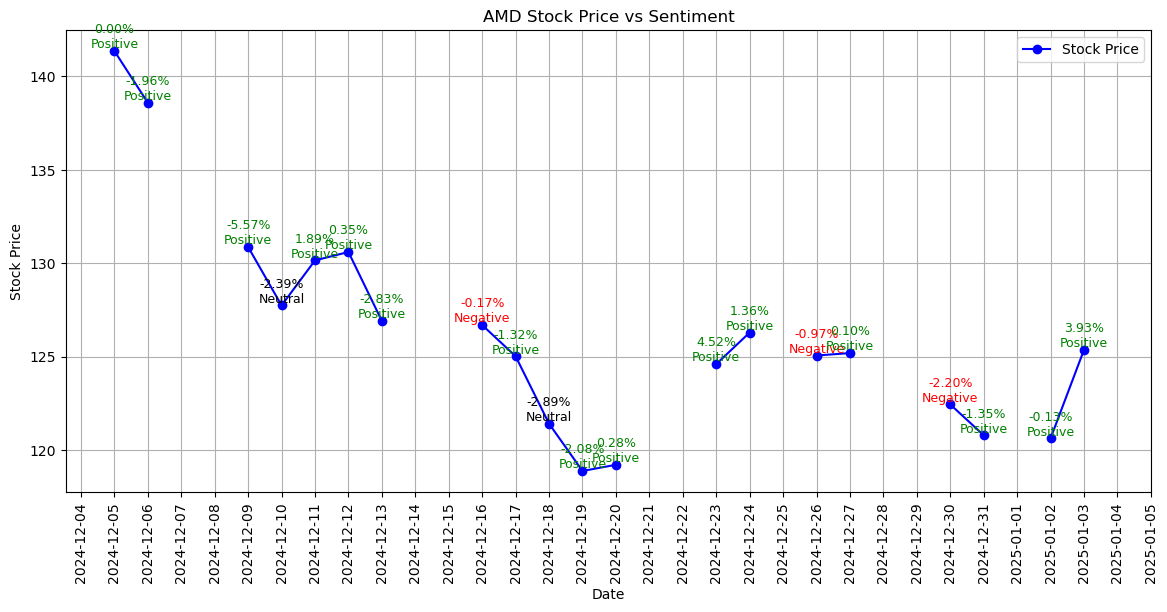

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


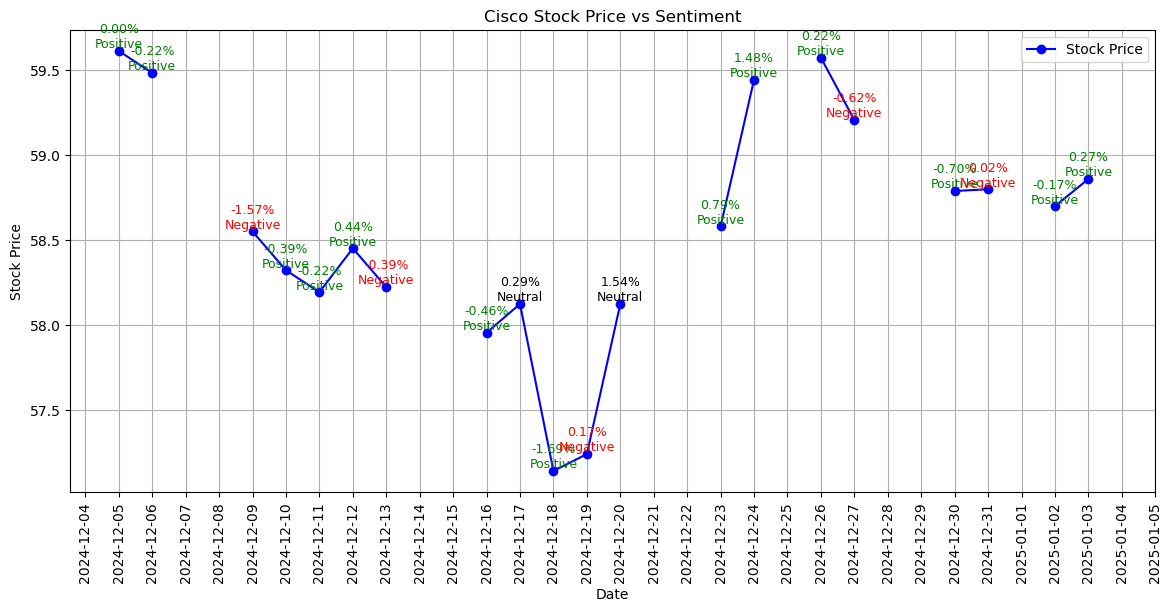

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


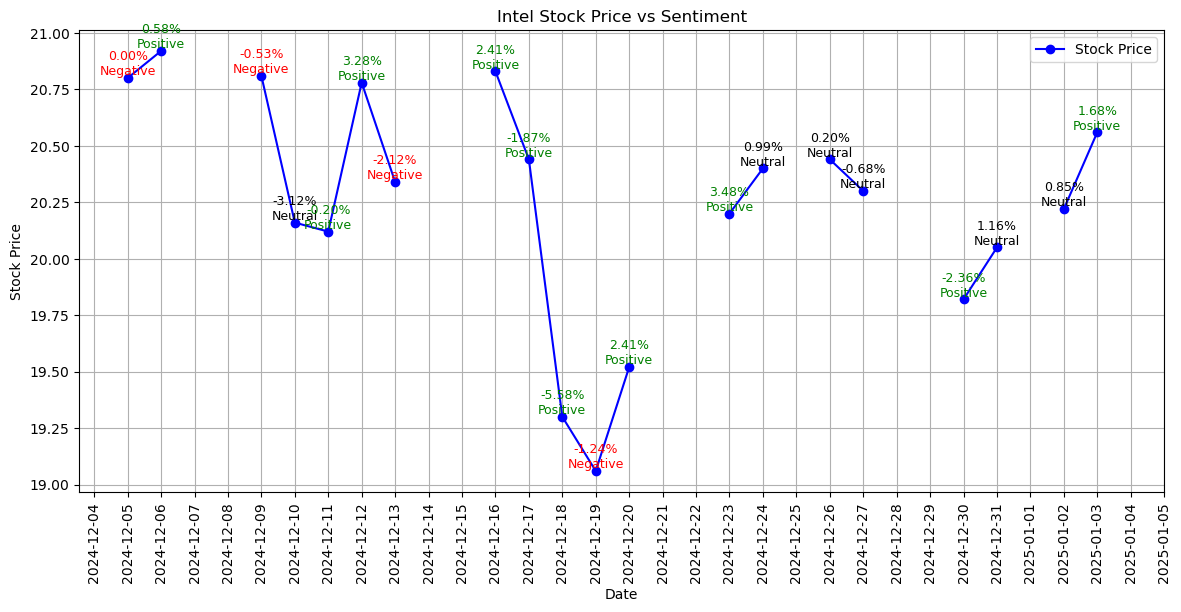

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


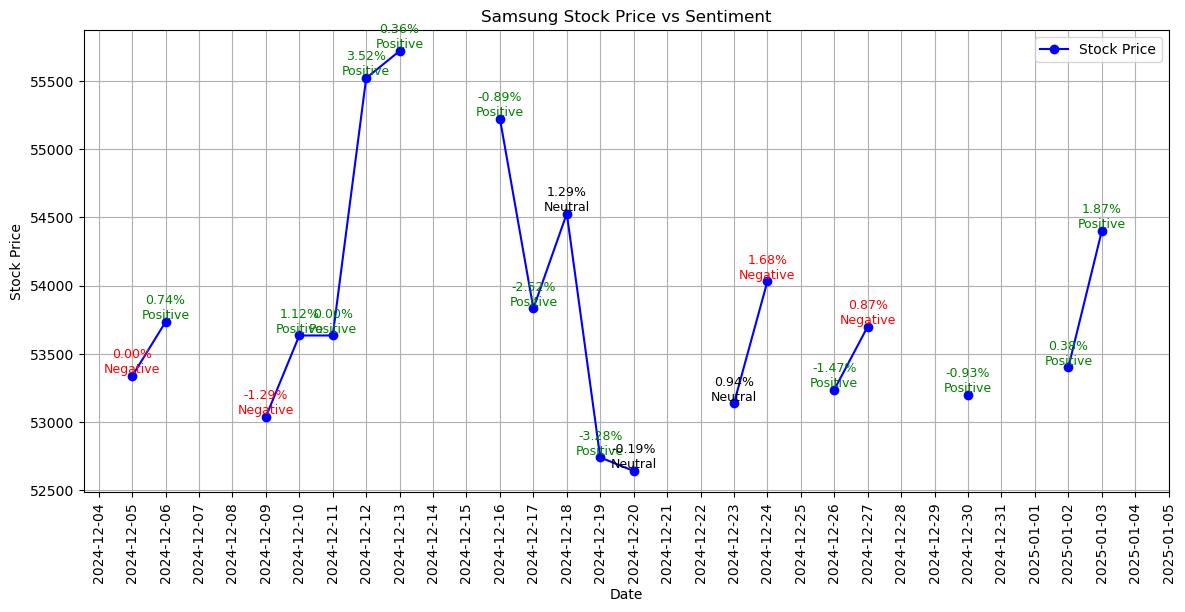

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


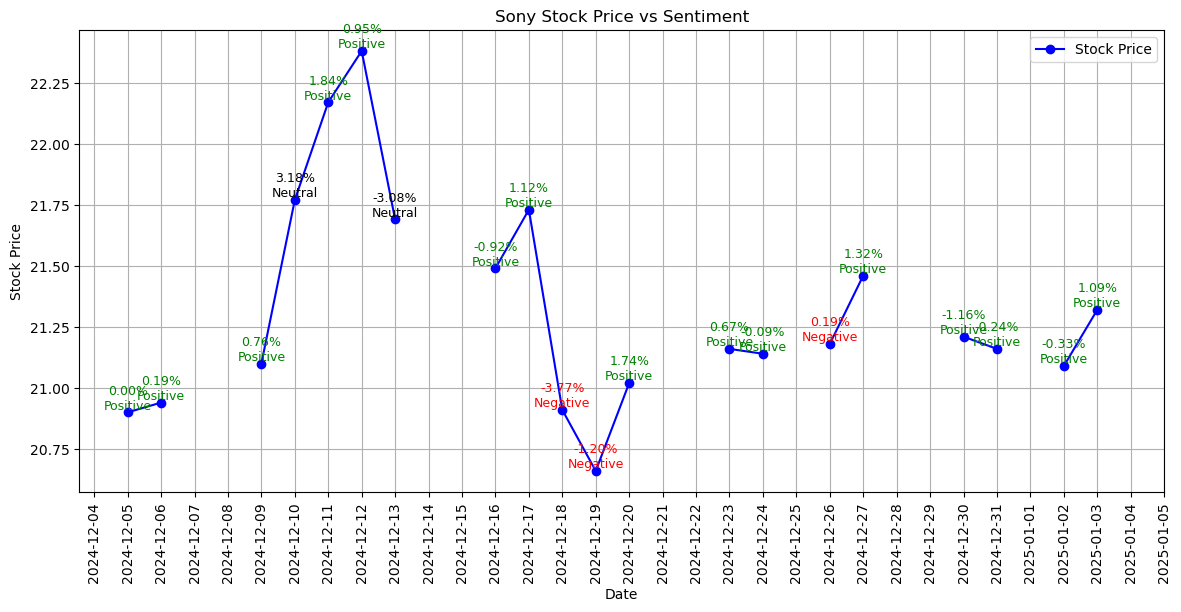

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


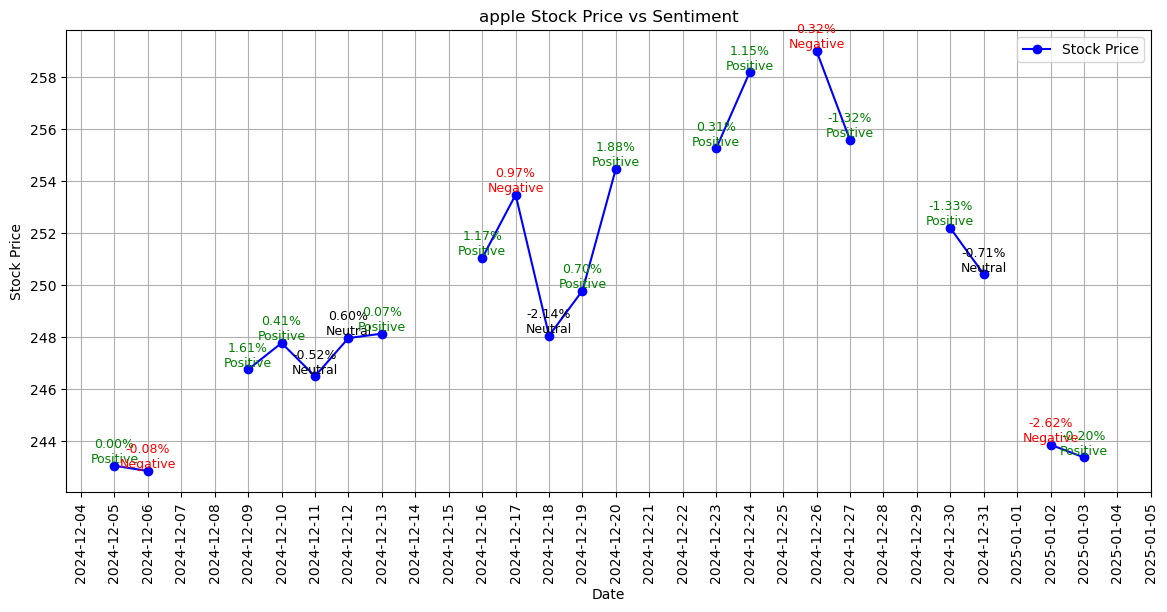

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


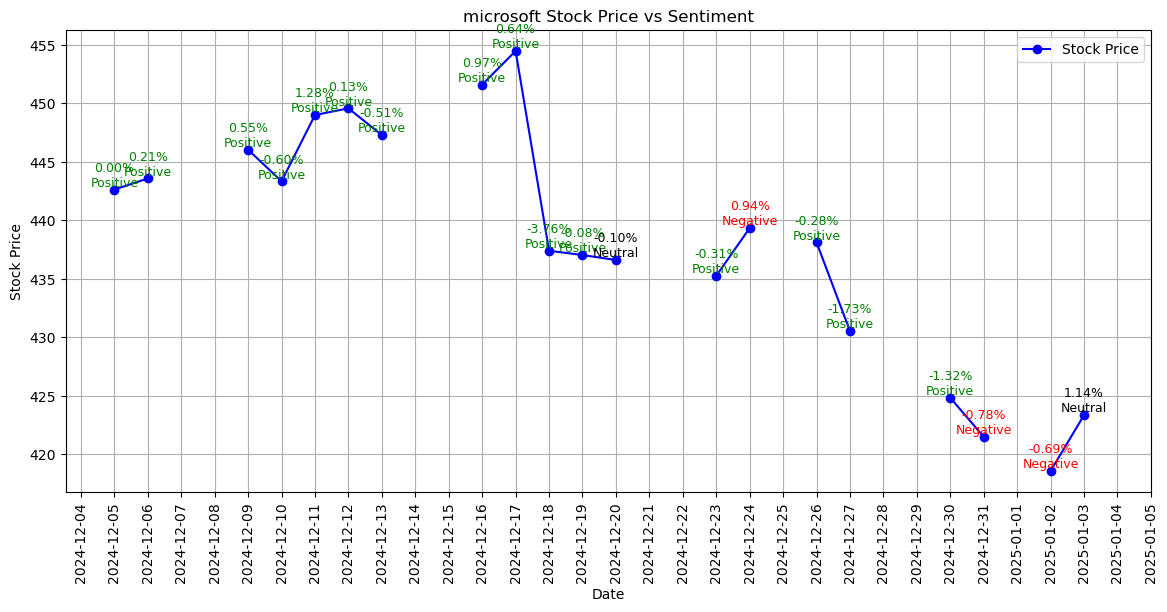

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


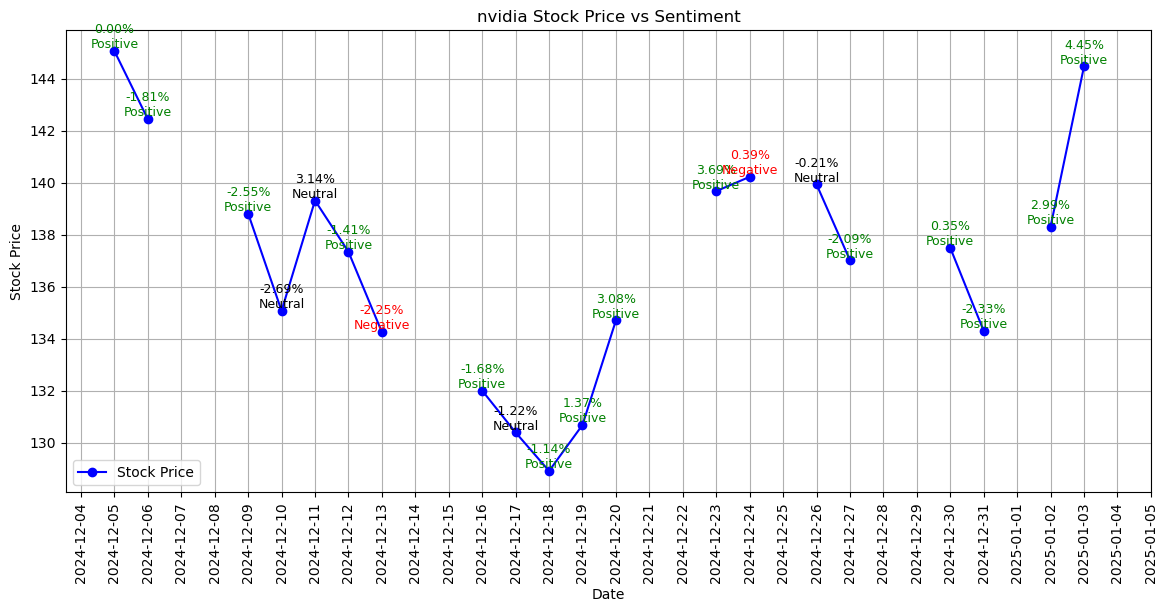

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


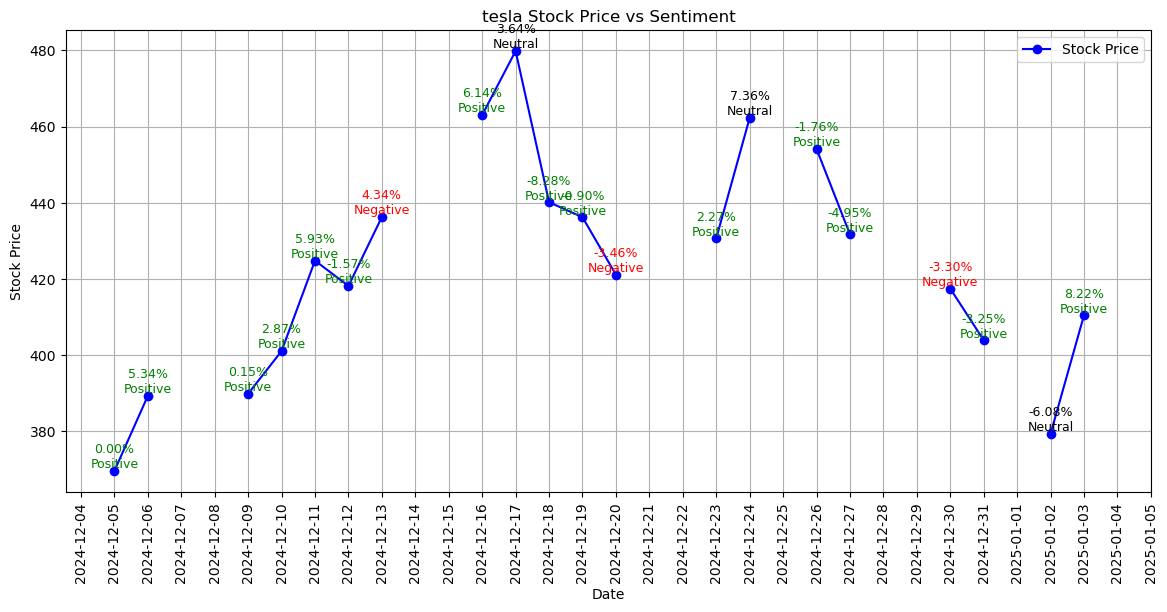

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the dataset
file_path = "combined_stock_sentiment_final.csv"  # Update with your actual file path
df = pd.read_csv(file_path)

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Get the list of all companies
companies = df["Company"].unique()

# Loop through each company and create a graph
for company_name in companies:
    # Filter data for the current company
    company_df = df[df["Company"] == company_name]

    # Sort by date to ensure correct order
    company_df = company_df.sort_values(by="Date")

    # ✅ Set the figure size
    plt.figure(figsize=(14, 6))

    # ✅ Plot stock prices as a continuous line
    plt.plot(company_df["Date"], company_df["Stock_Price"], linestyle="-", marker="o", color="blue", label="Stock Price")

    # ✅ Annotate each point with sentiment and percent change
    for i, row in company_df.iterrows():
        plt.text(row["Date"], row["Stock_Price"], 
                 f"{row['Stock_Price_Change']:.2f}%\n{row['Overall_Sentiment']}", 
                 fontsize=9, ha="center", va="bottom", 
                 color="red" if row["Overall_Sentiment"] == "Negative" else ("green" if row["Overall_Sentiment"] == "Positive" else "black"))

    # ✅ Formatting X-Axis to show **every date vertically**
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title(f"{company_name} Stock Price vs Sentiment")
    plt.xticks(company_df["Date"], rotation=90)  # ✅ Dates now appear exactly vertical
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format dates
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Show every date

    # ✅ Add grid and legend
    plt.legend()
    plt.grid()

    # ✅ Show the graph
    plt.show()


LAGGED CORRELATION

In [11]:
import pandas as pd

# Load the dataset
file_path = "combined_stock_sentiment_final.csv"  # Update with your actual file path
df = pd.read_csv(file_path)

# ✅ Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# ✅ Convert Sentiment into numerical values for correlation
sentiment_mapping = {"Positive": 1, "Neutral": 0, "Negative": -1}
df["Sentiment_Score"] = df["Overall_Sentiment"].map(sentiment_mapping)

# ✅ Shift Sentiment 1 day back (Lagging effect)
df["Lagged_Sentiment_Score"] = df.groupby("Company")["Sentiment_Score"].shift(1)

# ✅ Drop NaN values (first day will have NaN due to shifting)
df = df.dropna(subset=["Lagged_Sentiment_Score", "Stock_Price_Change"])

# ✅ Calculate overall correlation with lagged sentiment
lagged_correlation = df[["Lagged_Sentiment_Score", "Stock_Price_Change"]].corr().iloc[0, 1]

# ✅ Print the new correlation
print(f"📊 Correlation between Yesterday’s Sentiment and Today’s Stock Price Change: {lagged_correlation:.4f}")


📊 Correlation between Yesterday’s Sentiment and Today’s Stock Price Change: 0.0353


In [12]:
correlation_results = {}

for company in df["Company"].unique():
    company_df = df[df["Company"] == company].copy()  # Filter for one company

    # Apply lag only to this company's sentiment
    company_df["Lagged_Sentiment_Score"] = company_df["Sentiment_Score"].shift(1)

    # Drop NaN values
    company_df = company_df.dropna(subset=["Lagged_Sentiment_Score", "Stock_Price_Change"])

    # Calculate correlation
    correlation = company_df[["Lagged_Sentiment_Score", "Stock_Price_Change"]].corr().iloc[0, 1]

    # Store the result
    correlation_results[company] = correlation

# Convert to DataFrame for better viewing
correlation_df = pd.DataFrame(list(correlation_results.items()), columns=["Company", "Lagged_Correlation"])
print("📊 Company-wise Correlation (Yesterday's Sentiment → Today's Price Change):")
print(correlation_df)


📊 Company-wise Correlation (Yesterday's Sentiment → Today's Price Change):
     Company  Lagged_Correlation
0        AMD            0.279280
1      Cisco           -0.177737
2      Intel           -0.001089
3    Samsung            0.074159
4       Sony           -0.113487
5      apple            0.128509
6  microsoft           -0.029600
7     nvidia            0.044774
8      tesla            0.029938


ARIMA (TIME SERIES) FOR FUTURE PREDICTIONS WITHOUT CONSIDERING SENTIMENTS

Auto selecting best p,d,q for the model

Parameter Meaning,	When to Increase,	When to Decrease

p (AutoRegressive term) =	Number of past days used for prediction,	If trends exist & residuals are correlated,	If model is overfitting (too dependent on past values)

d (Differencing term) = 	Removes trend & makes data stationary,	If trend remains in differenced data,	If differencing causes loss of information

q (Moving Average term) =	Number of past forecast errors used,	If autocorrelation in residuals exists,	If model becomes too complex

In [14]:
pip install pmdarima

   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 625.1/625.1 kB 5.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------------------------------ --------- 2.1/2.8 MB 10.7 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 9.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd  # For handling data
from pmdarima import auto_arima  # To automatically find the best (p, d, q) values
import matplotlib.pyplot as plt  # For plotting ACF/PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # To analyze lags for AR and MA terms
from statsmodels.tsa.stattools import adfuller  # For checking stationarity

# ✅ Step 1: Load the dataset
file_path = "combined_stock_sentiment_final.csv"  # Update with your actual file path
df = pd.read_csv(file_path)

# ✅ Step 2: Convert Date column to datetime format
df["Date"] = pd.to_datetime(df["Date"])

# ✅ Step 3: Select one company (e.g., AMD) for forecasting
company_name = "AMD"  # Change to any company
company_df = df[df["Company"] == company_name]

# ✅ Step 4: Sort by Date and set it as the index (for time series modeling)
company_df = company_df.sort_values(by="Date")
company_df = company_df[["Date", "Stock_Price"]].set_index("Date")

# ✅ Step 5: Check if the data is stationary using the Augmented Dickey-Fuller (ADF) test
adf_test = adfuller(company_df["Stock_Price"])
print(f"ADF Statistic: {adf_test[0]}")  # Test statistic
print(f"P-Value: {adf_test[1]}")  # If > 0.05, the data is NOT stationary

# ✅ Step 6: Plot ACF and PACF to check for p and q values manually (optional)
plot_acf(company_df["Stock_Price"].diff().dropna(), lags=20)
plt.show()

plot_pacf(company_df["Stock_Price"].diff().dropna(), lags=20)
plt.show()

# ✅ Step 7: Use Auto ARIMA to find the best (p, d, q) values
#   - `seasonal=False` → Since stock prices usually don’t follow fixed seasonal patterns
#   - `trace=True` → Prints results of the model selection process
#   - `stepwise=True` → Uses an optimized search algorithm to find the best parameters faster
auto_arima_model = auto_arima(company_df["Stock_Price"], seasonal=False, trace=True, stepwise=True)

# ✅ Step 8: Get the best (p, d, q) values from Auto ARIMA
best_p, best_d, best_q = auto_arima_model.order
print(f"Best ARIMA Order: ({best_p}, {best_d}, {best_q})")


MissingDataError: exog contains inf or nans

FILLING THE HOLIDAY NULL STOCK PRICE ROWS WITH THE PREVIOUS DAY PRICES

In [16]:
import pandas as pd

# ✅ Step 1: Load the existing dataset
file_path = "combined_stock_sentiment_final.csv"  # Use your actual file path
df = pd.read_csv(file_path)

# ✅ Step 2: Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# ✅ Step 3: Sort by Company & Date to ensure correct order
df = df.sort_values(by=["Company", "Date"])

# ✅ Step 4: Forward-fill missing stock prices for each company
df["Stock_Price"] = df.groupby("Company")["Stock_Price"].ffill()

# ✅ Step 5: Overwrite the same dataset with updated values
df.to_csv(file_path, index=False)

# ✅ Step 6: Print confirmation & check if missing values are fixed
print("✅ Existing dataset updated: Missing stock prices filled with previous day's values!")
print(df.isna().sum())  # Should show 0 missing values in Stock_Price


✅ Existing dataset updated: Missing stock prices filled with previous day's values!
Date                  0
Company               0
Stock_Price           0
Stock_Price_Change    0
Overall_Sentiment     0
dtype: int64


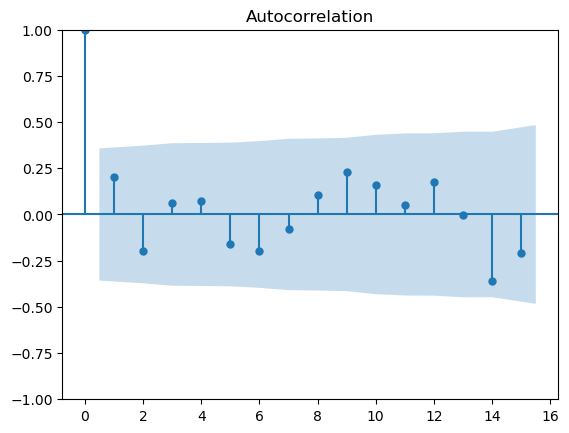

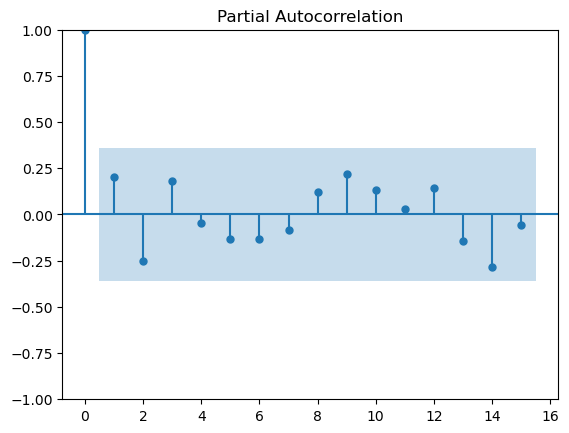

In [18]:
# Get a safe lag value (50% of available data)
max_lags = min(20, len(company_df) // 2)  

# Plot ACF
plot_acf(company_df["Stock_Price"].diff().dropna(), lags=max_lags)
plt.show()

# Plot PACF with adjusted lags
plot_pacf(company_df["Stock_Price"].diff().dropna(), lags=max_lags)
plt.show()


If both ACF and PACF drop between lag 0 and 1, this suggests that:


There is little autocorrelation in the stock price data, meaning the stock price follows a random walk.

A simple ARIMA(0,1,0) model (also called a "Random Walk" model) might be enough for forecasting.

Use auto_arima() to automatically determine the best number of previous days to consider:

In [19]:
from pmdarima import auto_arima
import pandas as pd

# Load dataset
file_path = "combined_stock_sentiment_final.csv"  # Update with your actual file path
df = pd.read_csv(file_path)

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Select one company (e.g., AMD)
company_name = "AMD"  
company_df = df[df["Company"] == company_name].sort_values(by="Date")
company_df = company_df[["Date", "Stock_Price"]].set_index("Date")

# Use Auto ARIMA to find best (p, d, q)
auto_arima_model = auto_arima(company_df["Stock_Price"], seasonal=False, trace=True, stepwise=True)

# Print best (p, d, q)
best_p, best_d, best_q = auto_arima_model.order
print(f"Best ARIMA Order: ({best_p}, {best_d}, {best_q})")


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=145.810, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=142.345, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=143.068, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=141.766, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=141.758, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=142.926, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.476 seconds
Best ARIMA Order: (0, 1, 0)


ARIMA MODEL

D:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_m

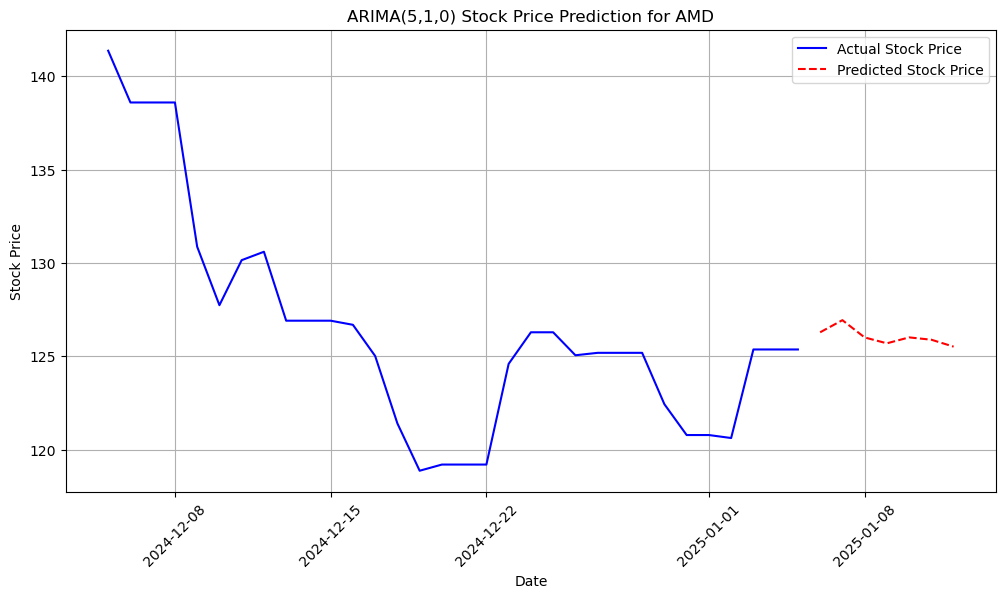

📈 Predicted Stock Prices for AMD (Next 7 Days):
         Date  Predicted_Stock_Price
31 2025-01-06             126.288640
32 2025-01-07             126.938811
33 2025-01-08             126.013347
34 2025-01-09             125.699474
35 2025-01-10             126.016330
36 2025-01-11             125.891770
37 2025-01-12             125.520528


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# ✅ Step 1: Load dataset
file_path = "combined_stock_sentiment_final.csv"  # Update with your actual file path
df = pd.read_csv(file_path)

# ✅ Step 2: Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# ✅ Step 3: Select AMD’s stock data
company_name = "AMD"  # Change if needed
company_df = df[df["Company"] == company_name].sort_values(by="Date")

# ✅ Step 4: Set Date as index (time series format)
company_df = company_df[["Date", "Stock_Price"]].set_index("Date")

# ✅ Step 5: Train ARIMA(2,1,2) model
model = ARIMA(company_df["Stock_Price"], order=(5,1,0))
model_fit = model.fit()

# ✅ Step 6: Forecast next 7 days
forecast = model_fit.forecast(steps=7)

# ✅ Step 7: Create DataFrame for predictions
future_dates = pd.date_range(start=company_df.index[-1], periods=8, freq='D')[1:]
forecast_df = pd.DataFrame({"Date": future_dates, "Predicted_Stock_Price": forecast})

# ✅ Step 8: Plot actual vs predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(company_df.index, company_df["Stock_Price"], label="Actual Stock Price", color="blue")
plt.plot(forecast_df["Date"], forecast_df["Predicted_Stock_Price"], label="Predicted Stock Price", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"ARIMA(5,1,0) Stock Price Prediction for {company_name}")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# ✅ Step 9: Print predictions
print(f"📈 Predicted Stock Prices for {company_name} (Next 7 Days):")
print(forecast_df)


MULTIVARIATE ARIMA MODEL USING SENTIMENTS

SARIMAX (Seasonal AutoRegressive Integrated Moving Average with Exogenous Variables)

D:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: 

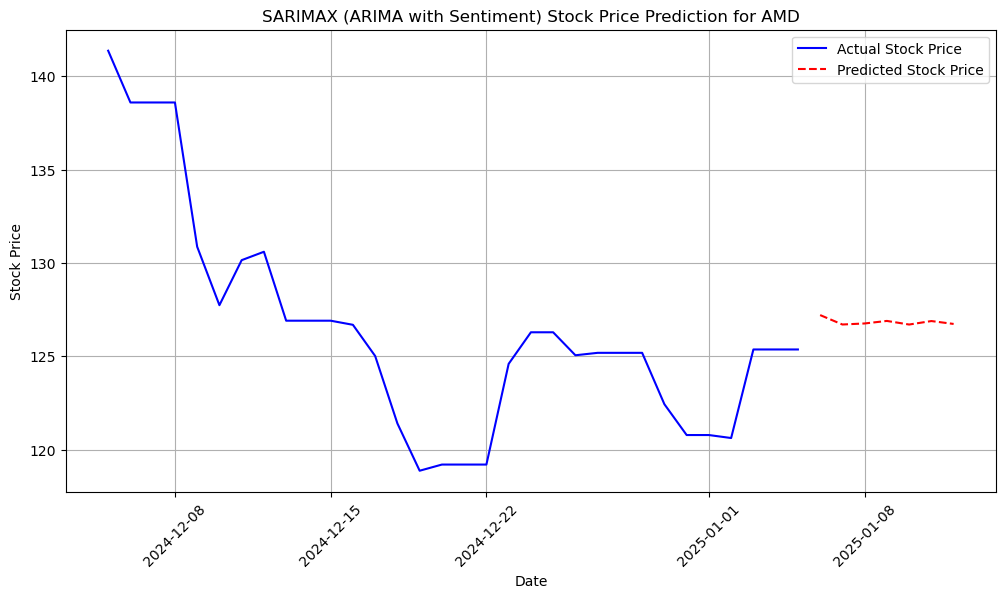

📈 Predicted Stock Prices for AMD (Next 7 Days) with Sentiment:
         Date  Predicted_Stock_Price
31 2025-01-06             127.210790
32 2025-01-07             126.706444
33 2025-01-08             126.761735
34 2025-01-09             126.897714
35 2025-01-10             126.704776
36 2025-01-11             126.891254
37 2025-01-12             126.736056


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX  # For multivariate ARIMA

# ✅ Step 1: Load dataset
file_path = "combined_stock_sentiment_final.csv"  # Update with actual file path
df = pd.read_csv(file_path)

# ✅ Step 2: Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# ✅ Step 3: Select AMD’s stock data
company_name = "AMD"
company_df = df[df["Company"] == company_name].sort_values(by="Date")

# ✅ Step 4: Convert Sentiment to Numeric Values
sentiment_mapping = {"Positive": 1, "Neutral": 0, "Negative": -1}
company_df["Sentiment_Score"] = company_df["Overall_Sentiment"].map(sentiment_mapping)

# ✅ Step 5: Set Date as Index and Select Features
company_df = company_df[["Date", "Stock_Price", "Sentiment_Score"]].set_index("Date")

# ✅ Step 6: Train Multivariate ARIMA (SARIMAX) Model
model = SARIMAX(
    company_df["Stock_Price"],  # Dependent variable (Stock Price)
    exog=company_df["Sentiment_Score"],  # Independent variable (Sentiment)
    order=(2,1,2),  # ARIMA order (p,d,q) - Can be tuned using Auto ARIMA
    seasonal_order=(0,0,0,0)  # No seasonality
)
model_fit = model.fit()

# ✅ Step 7: Forecast Next 7 Days
future_sentiment = [0] * 7  # Assume neutral sentiment for future (can be adjusted)
forecast = model_fit.forecast(steps=7, exog=future_sentiment)

# ✅ Step 8: Create DataFrame for Predictions
future_dates = pd.date_range(start=company_df.index[-1], periods=8, freq='D')[1:]
forecast_df = pd.DataFrame({"Date": future_dates, "Predicted_Stock_Price": forecast})

# ✅ Step 9: Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(company_df.index, company_df["Stock_Price"], label="Actual Stock Price", color="blue")
plt.plot(forecast_df["Date"], forecast_df["Predicted_Stock_Price"], label="Predicted Stock Price", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"SARIMAX (ARIMA with Sentiment) Stock Price Prediction for {company_name}")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# ✅ Step 10: Print Predictions
print(f"📈 Predicted Stock Prices for {company_name} (Next 7 Days) with Sentiment:")
print(forecast_df)


LSTM ( Long Short-Term Memory.)


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.0583 - val_loss: 0.0393
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0411 - val_loss: 0.0273
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.0291 - val_loss: 0.0187
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 0.0219 - val_loss: 0.0132
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.0194 - val_loss: 0.0109
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.0209 - val_loss: 0.0107
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0238 - val_loss: 0.0110
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0251 - val_loss: 0.0110
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.0245 - val_loss: 0.0108
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0229 - val_loss: 0.0108
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.0210 - val_loss: 0.0110
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.0195 - val_loss:

C:\Users\siddh\AppData\Local\Temp\ipykernel_20304\3365727688.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_days[0, -1, 0] = pred  # Add new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


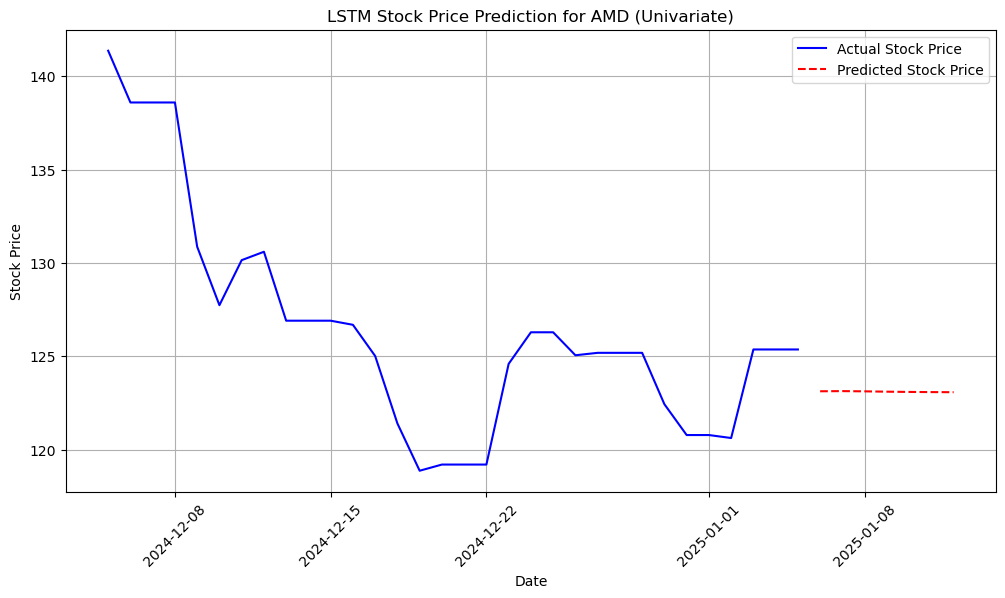

📈 Predicted Stock Prices for AMD (Next 7 Days):
        Date  Predicted_Stock_Price
0 2025-01-06             123.132759
1 2025-01-07             123.140877
2 2025-01-08             123.128876
3 2025-01-09             123.110794
4 2025-01-10             123.097076
5 2025-01-11             123.088326
6 2025-01-12             123.082993


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ✅ Step 1: Load dataset
file_path = "combined_stock_sentiment_final.csv"  # Update with actual file path
df = pd.read_csv(file_path)

# ✅ Step 2: Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# ✅ Step 3: Select AMD’s stock data
company_name = "AMD"
company_df = df[df["Company"] == company_name].sort_values(by="Date")
company_df = company_df[["Date", "Stock_Price"]].set_index("Date")

# ✅ Step 4: Normalize stock prices (LSTMs work better with scaled data)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(company_df)

# ✅ Step 5: Prepare data for LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Take previous `seq_length` days as input
        y.append(data[i+seq_length])    # Predict the next day’s price
    return np.array(X), np.array(y)

seq_length = 10  # Number of past days used for prediction
X, y = create_sequences(scaled_data, seq_length)

# ✅ Step 6: Split data into training and testing sets
split = int(len(X) * 0.8)  # 80% train, 20% test
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# ✅ Step 7: Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),  # First LSTM layer
    LSTM(50, return_sequences=False),  # Second LSTM layer
    Dense(25),  # Fully connected layer
    Dense(1)  # Output layer (predicts stock price)
])

# ✅ Step 8: Compile model
model.compile(optimizer="adam", loss="mean_squared_error")

# ✅ Step 9: Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# ✅ Step 10: Predict future stock prices
last_days = scaled_data[-seq_length:]  # Get last `seq_length` days
last_days = np.expand_dims(last_days, axis=0)  # Reshape for LSTM

predictions = []
for _ in range(7):  # Predict next 7 days
    pred = model.predict(last_days)[0]
    predictions.append(pred)
    last_days = np.roll(last_days, -1, axis=1)  # Shift data
    last_days[0, -1, 0] = pred  # Add new prediction

# ✅ Step 11: Convert predictions back to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# ✅ Step 12: Create DataFrame for predictions
future_dates = pd.date_range(start=company_df.index[-1], periods=8, freq='D')[1:]
forecast_df = pd.DataFrame({"Date": future_dates, "Predicted_Stock_Price": predictions.flatten()})

# ✅ Step 13: Plot actual vs predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(company_df.index, company_df["Stock_Price"], label="Actual Stock Price", color="blue")
plt.plot(forecast_df["Date"], forecast_df["Predicted_Stock_Price"], label="Predicted Stock Price", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"LSTM Stock Price Prediction for {company_name} (Univariate)")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# ✅ Step 14: Print predictions
print(f"📈 Predicted Stock Prices for {company_name} (Next 7 Days):")
print(forecast_df)


In [31]:
!pip install tensorflow


   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 0.8/390.3 MB 4.8 MB/s eta 0:01:22
   ---------------------------------------- 2.1/390.3 MB 5.6 MB/s eta 0:01:10
   ---------------------------------------- 3.4/390.3 MB 5.6 MB/s eta 0:01:10
   ---------------------------------------- 4.7/390.3 MB 5.8 MB/s eta 0:01:07
    --------------------------------------- 5.8/390.3 MB 5.9 MB/s eta 0:01:06
    --------------------------------------- 7.3/390.3 MB 5.9 MB/s eta 0:01:06
    --------------------------------------- 8.4/390.3 MB 5.8 MB/s eta 0:01:06
    --------------------------------------- 9.7/390.3 MB 5.8 MB/s eta 0:01:06
   - -------------------------------------- 11.0/390.3 MB 6.0 MB/s eta 0:01:04
   - -------------------------------------- 12.6/390.3 MB 6.1 MB/s eta 0:01:02
   - -------------------------------------- 13.9/390.3 MB 6.1 MB/s eta 0:01:02
   - -------------------------------------- 15.2/390.3 MB 6.2 MB/s e